In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn import linear_model, preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestRegressor

In [2]:
data = pd.read_csv('student-mat.csv')
#data = data.rename(columns = {'G1': 'first_period_grade', 'G2': 'second_period_grade', 'G3': 'final_grade'})
data = data.rename(columns = {'G3': 'final_grade'})
#data.head().T

In [3]:
#Drop unnecessary columns
#unnecessary_cols = ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime']
unnecessary_cols = ['age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime']
data = data.drop(columns=unnecessary_cols)
#data.head().T

In [4]:
#Create dummy variables
#data = data.replace({'yes': 1, 'no': 0})
data = pd.get_dummies(data)
#data.info()

In [5]:
#Train test split
drop_cols = ['final_grade']
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=drop_cols), 
                                                    data.final_grade, 
                                                    test_size = 0.25,
                                                    random_state=1)

In [61]:
#Linear Regression Model (unscaled)
lm = LinearRegression()
lm.fit(X_train, y_train)
y_tr_pred = lm.predict(X_train)
y_te_pred = lm.predict(X_test)

#Assess performance
print('Scores for Linear Regression Model (unscaled):')
print('R2 Score for Tr Data:', r2_score(y_train, y_tr_pred))
print('R2 Score for Te Data:', r2_score(y_test, y_te_pred))

#Cross validate Linear Regression Model (unscaled)
cv_results = cross_validate(lm, X_train, y_train, cv=5)
cv_scores = cv_results['test_score']
print("Mean CV Score:", cv_scores.mean())
print("Std CV Score:", cv_scores.std())

Scores for Linear Regression Model (unscaled):
R2 Score for Tr Data: 0.8518067240464127
R2 Score for Te Data: 0.7743998335638442
Mean CV Score: 0.817536331965481
Std CV Score: 0.03600917861501178


In [59]:
#Linear Regression Model (scaled)
pipe = make_pipeline(
    StandardScaler(),
    LinearRegression()
)

pipe.fit(X_train, y_train)
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

#Assess performance
print('Scores for Linear Regression Model (scaled):')
print('R2 Score for Tr Data:', r2_score(y_train, y_tr_pred))
print('R2 Score for Te Data:', r2_score(y_test, y_te_pred))

#Cross validate Linear Regression Model (scaled)
cv_results = cross_validate(pipe, X_train, y_train, cv=5)
cv_scores = cv_results['test_score']
print("Mean CV Score:", cv_scores.mean())
print("Std CV Score:", cv_scores.std())

Scores for Linear Regression Model (scaled):
R2 Score for Tr Data: 0.8509592480191737
R2 Score for Te Data: 0.7771609011512856
Mean CV Score: 0.8163850484409295
Std CV Score: 0.03738243971439127


**Select K Best Features**

In [62]:
pipe = make_pipeline(
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

pipe.fit(X_train, y_train)
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

#Assess performance
print('Scores for Linear Regression Model (K_Best):')
print('R2 Score for Tr Data:', r2_score(y_train, y_tr_pred))
print('R2 Score for Te Data:', r2_score(y_test, y_te_pred))

#Cross validate Linear Regression Model (K_Best)
cv_results = cross_validate(pipe, X_train, y_train, cv=5)
cv_scores = cv_results['test_score']
print("Mean CV Score:", cv_scores.mean())
print("Std CV Score:", cv_scores.std())

Scores for Linear Regression Model (K_Best):
R2 Score for Tr Data: 0.8404894492167373
R2 Score for Te Data: 0.7593229409701225
Mean CV Score: 0.8253073564992304
Std CV Score: 0.03299422642411993


**Feature Selection**

In [43]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'selectkbest', 'linearregression', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize', 'linearregression__positive'])

In [87]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

pipe = make_pipeline(
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)
lr_grid_cv.fit(X_train, y_train)
y_tr_pred = lr_grid_cv.predict(X_train)
y_te_pred = lr_grid_cv.predict(X_test)

score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

#lr_grid_cv.best_params_

selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

G2    3.856621
G1    0.529323
dtype: float64

In [88]:
#Assess performance
print('Scores for Linear Regression Model (Grid Search):')
print('R2 Score for Tr Data:', r2_score(y_train, y_tr_pred))
print('R2 Score for Te Data:', r2_score(y_test, y_te_pred))

#Cross validate Linear Regression Model (Grid Search)
print("Mean CV Score:", score_mean.mean())
print("Std CV Score:", score_std.std())

Scores for Linear Regression Model (Grid Search):
R2 Score for Tr Data: 0.8356359218036558
R2 Score for Te Data: 0.7671946765442308
Mean CV Score: 0.8208325244153356
Std CV Score: 0.0029309218432459544


**Random Forest**

In [63]:
rf_pipe = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(random_state=1)
)

rf_cv = cross_validate(rf_pipe, X_train, y_train, cv=5)
rf_cv_scores = rf_cv['test_score']
print('Random Forest Regressor:')
print("Mean CV Score:", rf_cv_scores.mean())
print("Std CV Score:", rf_cv_scores.std())

Random Forest Regressor:
Mean CV Score: 0.8600534884351905
Std CV Score: 0.038888387108360754


In [71]:
#Grid Search
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None],
}

rf_grid_cv = GridSearchCV(rf_pipe, param_grid=grid_params, cv=5, n_jobs=-1)
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=1))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143, 183, 233,
                                                                 297, 379, 483,
                                                                 615, 784,
                                                                 1000],
                         'standardscaler': [StandardScaler(), None]})

In [72]:
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 615,
 'standardscaler': StandardScaler()}

In [75]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']

print("Mean CV Score:", rf_best_scores.mean())
print("Std CV Score:", rf_best_scores.std())

Mean CV Score: 0.8637076186423445
Std CV Score: 0.03494308544693526


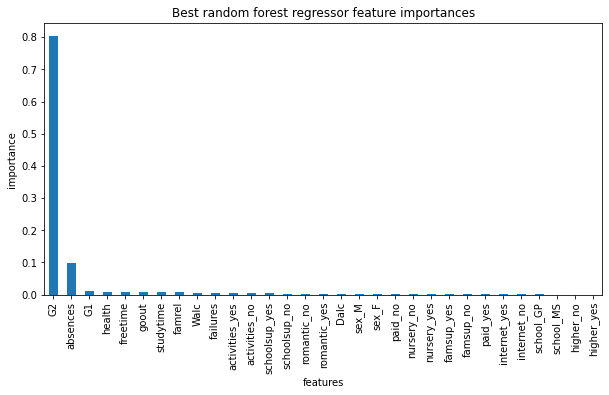

In [76]:
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

**Model Selection**

In [85]:
#Linear Regression
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
print('Mean:', lr_mae_mean)
print('Std :', lr_mae_std)
print('MAE :', mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test)))

Mean: 1.1295931860227588
Std : 0.09655760604751538
MAE : 1.1687389321754165


In [86]:
#Random Forest
rf_neg_mae = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
print('Mean:', rf_mae_mean)
print('Std :', rf_mae_std)
print('MAE :', mean_absolute_error(y_test, rf_grid_cv.best_estimator_.predict(X_test)))

Mean: 1.0212092232786734
Std : 0.095313749464914
MAE : 1.0502422599983576
